In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import time
import sys

# Ajouter le chemin si nécessaire
# sys.path.insert(0, '/path/to/your/RLT')

from Models.registry import get_benchmark_models, analyze_rlt_results, compute_p0

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

print("✓ Imports OK")

✓ Imports OK


In [2]:
def generate_scenario2(n_train=100, n_test=1000, p=200, random_state=0):
    """
    Scénario 2 EXACT de l'article Zhu et al. (2015), Section 4.2
    """
    rng = np.random.default_rng(random_state)
    
    # Train
    X_train = rng.uniform(0, 1, size=(n_train, p))
    eps_train = rng.normal(0, 1, size=n_train)
    # FORMULE CORRECTE : 100 * (X1-0.5)² * max(X2-0.25, 0)
    f_train = 100 * (X_train[:, 0] - 0.5)**2 * np.maximum(X_train[:, 1] - 0.25, 0)
    y_train = f_train + eps_train
    
    # Test
    X_test = rng.uniform(0, 1, size=(n_test, p))
    eps_test = rng.normal(0, 1, size=n_test)
    f_test = 100 * (X_test[:, 0] - 0.5)**2 * np.maximum(X_test[:, 1] - 0.25, 0)
    y_test = f_test + eps_test
    
    return X_train, y_train, X_test, y_test

✓ Données générées
  X_train : (100, 200)
  X_test  : (1000, 200)
  y_train : min=-2.31, max=19.63, mean=2.21


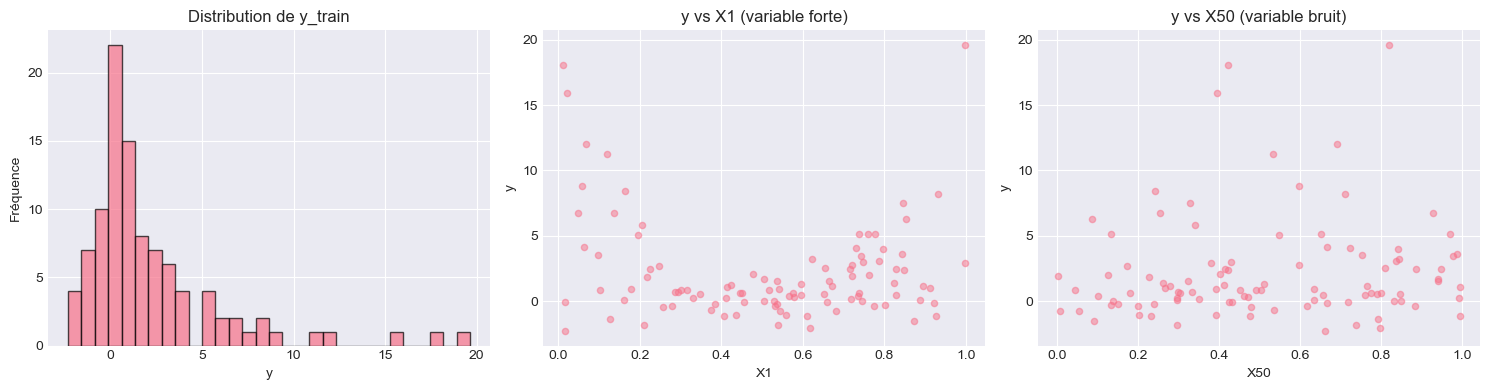

Pour p=200 :
  p_0 calculé      : 5
  log(p)           : 5.30
  % de features    : 2.50%
  Variables fortes : 3 (X1, X2, X3)
  ✓ p_0=5 couvre bien les 3 variables fortes
[INFO] p=200 → p_0=5 (selon article : log(200) ≈ 5.30)

✓ 14 modèles créés :

Baselines :
  - RF
  - ET
  - GBR
  - Lasso
  - ElasticNet

RLT (9 variantes) :
  - RLT_none_k1
  - RLT_none_k2
  - RLT_none_k5
  - RLT_moderate_k1
  - RLT_moderate_k2
  - RLT_moderate_k5
  - RLT_aggressive_k1
  - RLT_aggressive_k2
  - RLT_aggressive_k5

                           ENTRAÎNEMENT ET ÉVALUATION                           

[ 1/14] RF                             ✓ MSE =  13.0656  (  2.3s)
[ 2/14] ET                             ✓ MSE =  13.2401  (  2.1s)
[ 3/14] GBR                            ✓ MSE =   8.4649  (  6.6s)
[ 4/14] Lasso                          ✓ MSE =  23.1611  (  0.0s)
[ 5/14] ElasticNet                     ✓ MSE =  21.6992  (  0.0s)
[ 6/14] RLT_none_k1                    [RLT] Arbre 1/20 construit
[RLT] Arbre 10/20 c

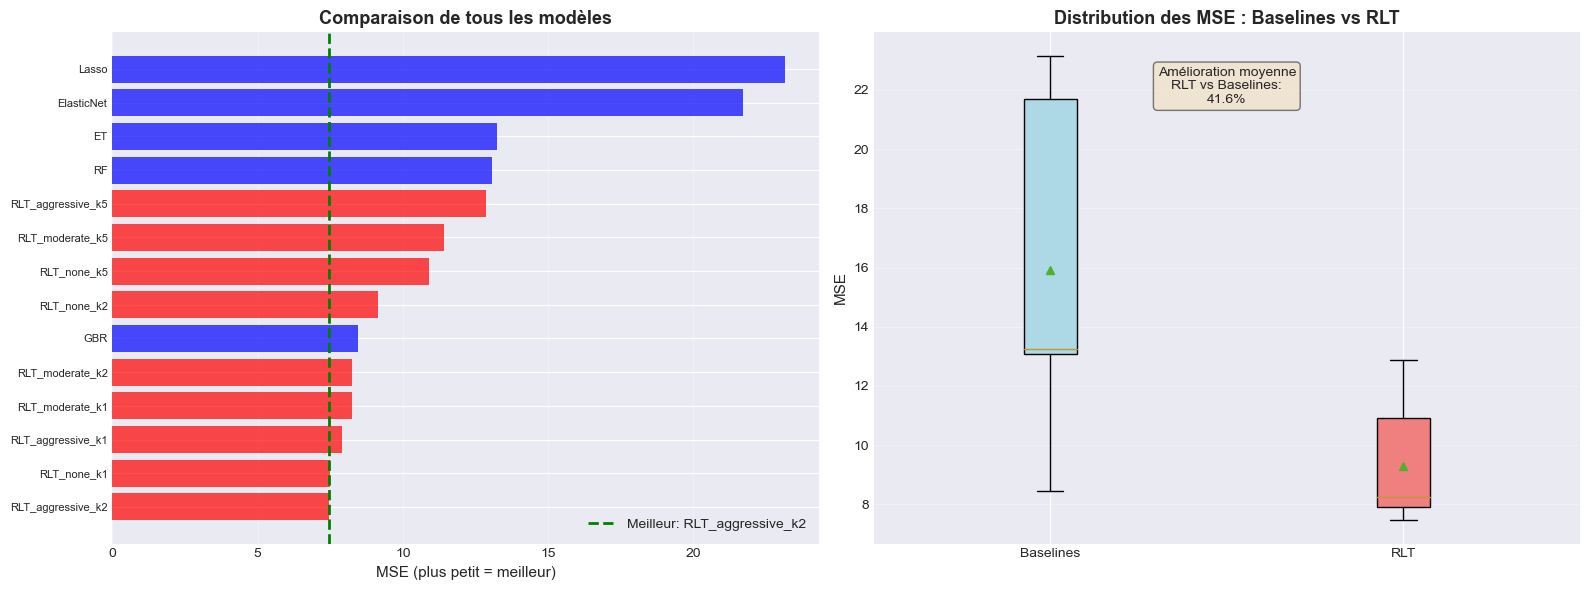

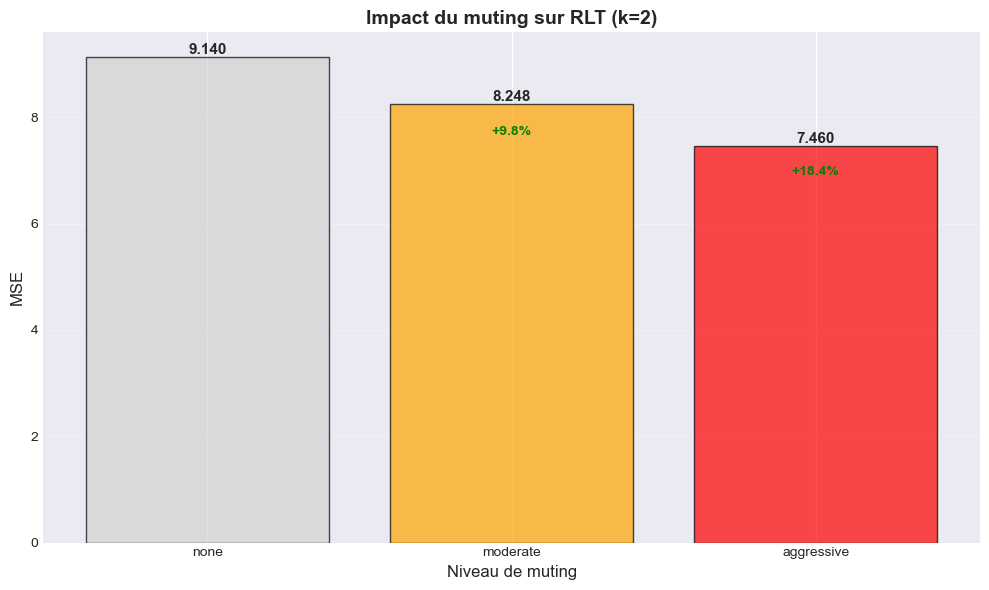


📊 IMPACT DU MUTING (k=2) :
  none         : MSE = 9.1397
  moderate     : MSE = 8.2485
  aggressive   : MSE = 7.4599

  Amélioration vs 'none' :
    moderate     : +9.8%
    aggressive   : +18.4%


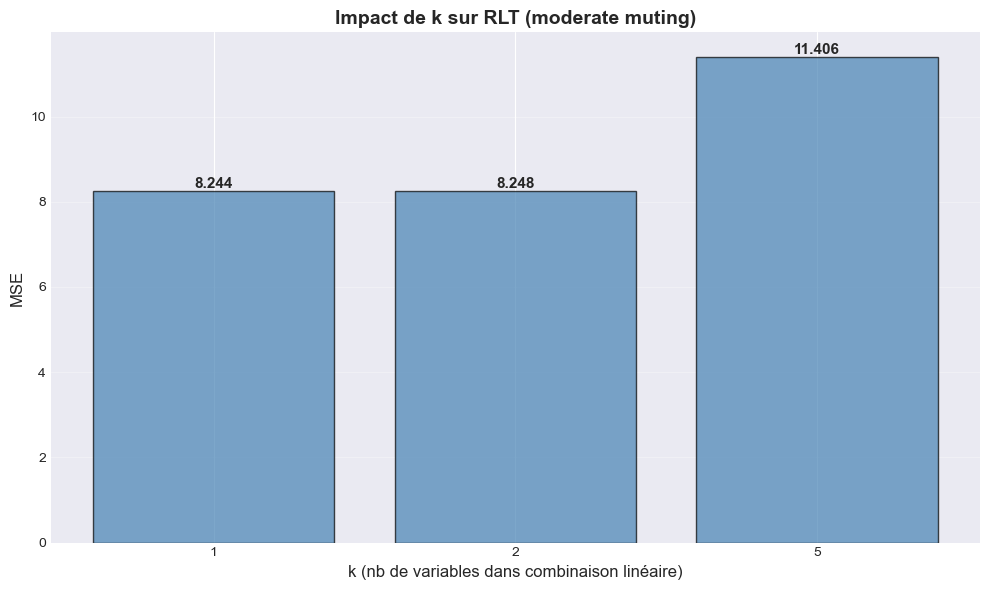


📊 IMPACT DE K (moderate muting) :
  k=1 : MSE = 8.2442
  k=2 : MSE = 8.2485
  k=5 : MSE = 11.4059


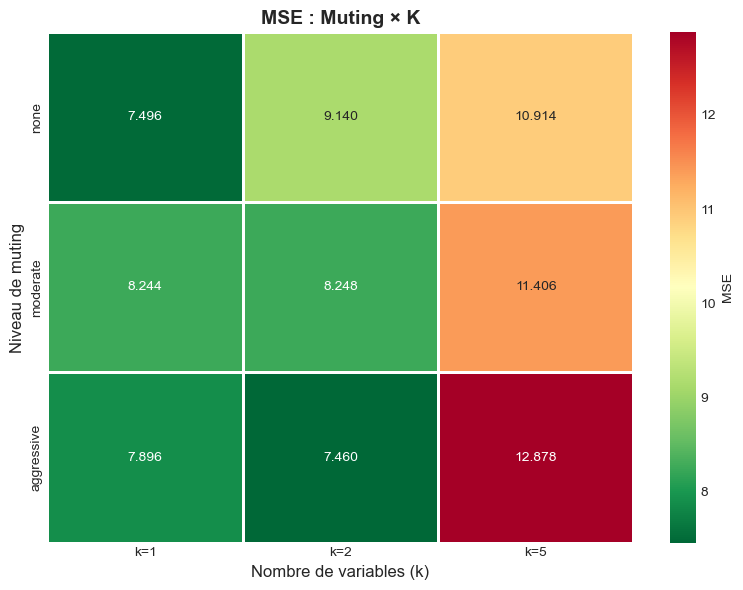


🏆 MEILLEURE CONFIGURATION : muting=aggressive, k=2 (MSE=7.4599)

⏱️  TEMPS D'EXÉCUTION :
            model  train_time  predict_time  total_time     type
       ElasticNet    0.008001      0.001006    0.009007 Baseline
            Lasso    0.042919      0.001999    0.044918 Baseline
               ET    2.055171      0.468831    2.524001 Baseline
               RF    2.304111      0.298738    2.602849 Baseline
              GBR    6.565912      0.007001    6.572913 Baseline
RLT_aggressive_k1   48.662037      0.054002   48.716039      RLT
RLT_aggressive_k2   49.379676      0.067993   49.447670      RLT
  RLT_moderate_k5   56.178082      0.061005   56.239088      RLT
  RLT_moderate_k1   63.113923      0.058987   63.172910      RLT
RLT_aggressive_k5   64.311192      0.089000   64.400192      RLT


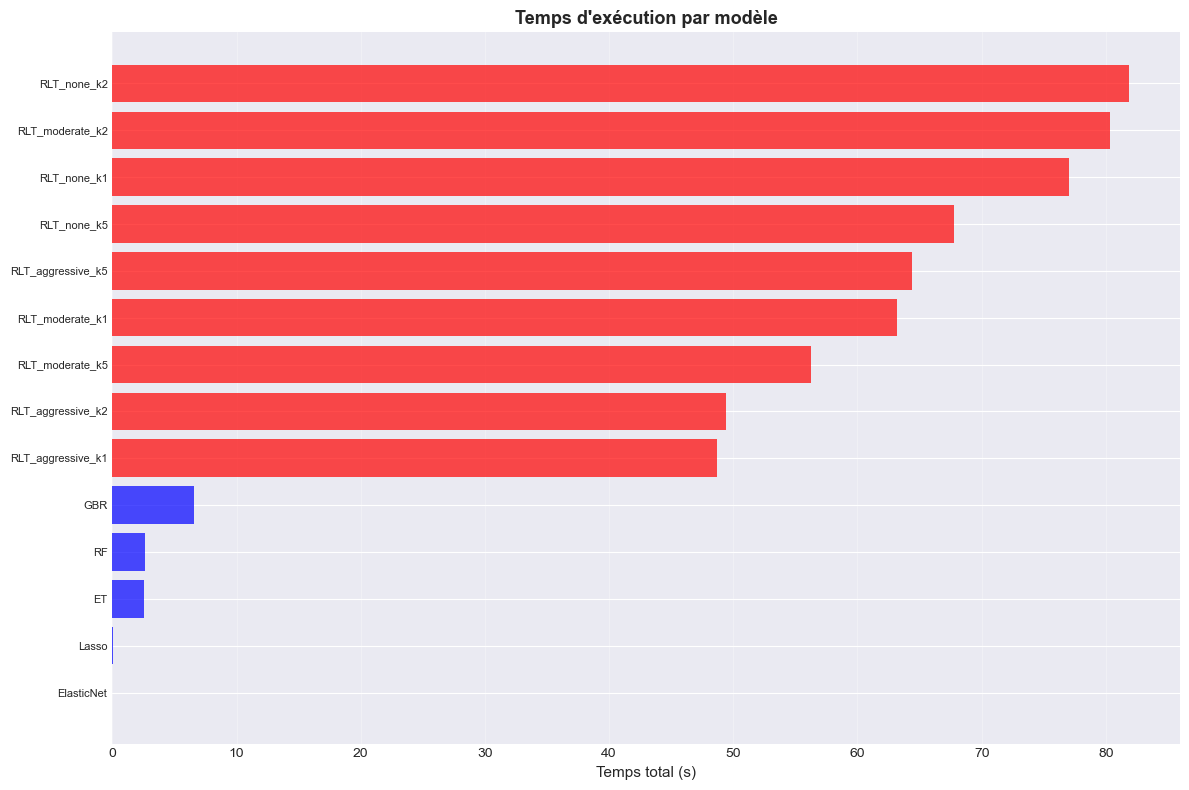


                              RÉCAPITULATIF FINAL                               

📊 DONNÉES :
  n_train = 100, n_test = 1000, p = 200
  Variables fortes : 3 (X1, X2, X3)
  p_0 calculé : 5

🏆 MEILLEUR MODÈLE :
  Nom : RLT_aggressive_k2
  MSE : 7.4599

📈 MEILLEUR RLT vs MEILLEURE BASELINE :
  RLT      : RLT_aggressive_k2    MSE = 7.4599
  Baseline : GBR                  MSE = 8.4649
  ✅ RLT gagne : 11.9% d'amélioration!

⏱️  TEMPS MOYEN :
  Baseline : 2.4s
  RLT      : 65.4s

                                 ✅ TEST TERMINÉ                                 

✓ Résultats sauvegardés : results_scenario2_rlt.csv


In [3]:
# Générer les données
p = 200
n_train = 100
n_test = 1000

X_train, y_train, X_test, y_test = generate_scenario2(
    n_train=n_train, 
    n_test=n_test, 
    p=p, 
    random_state=42
)

print(f"✓ Données générées")
print(f"  X_train : {X_train.shape}")
print(f"  X_test  : {X_test.shape}")
print(f"  y_train : min={y_train.min():.2f}, max={y_train.max():.2f}, mean={y_train.mean():.2f}")

# Visualisation rapide
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Distribution de y
axes[0].hist(y_train, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution de y_train')
axes[0].set_xlabel('y')
axes[0].set_ylabel('Fréquence')

# Relation y vs X1 (principale variable)
axes[1].scatter(X_train[:, 0], y_train, alpha=0.5, s=20)
axes[1].set_title('y vs X1 (variable forte)')
axes[1].set_xlabel('X1')
axes[1].set_ylabel('y')

# Relation y vs X50 (variable bruit)
axes[2].scatter(X_train[:, 50], y_train, alpha=0.5, s=20)
axes[2].set_title('y vs X50 (variable bruit)')
axes[2].set_xlabel('X50')
axes[2].set_ylabel('y')

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 3. Vérification de p_0

# %%
# Vérifier le calcul de p_0
p_0_calculated = compute_p0(p)
print(f"Pour p={p} :")
print(f"  p_0 calculé      : {p_0_calculated}")
print(f"  log(p)           : {np.log(p):.2f}")
print(f"  % de features    : {p_0_calculated/p*100:.2f}%")
print(f"  Variables fortes : 3 (X1, X2, X3)")
print(f"  ✓ p_0={p_0_calculated} couvre bien les 3 variables fortes")

# %% [markdown]
# ## 4. Obtenir tous les modèles

# %%
# ✅ IMPORTANT : Passer p pour calcul automatique de p_0
models = get_benchmark_models("regression", p=p, random_state=42)

print(f"\n✓ {len(models)} modèles créés :")
print("\nBaselines :")
for name in models.keys():
    if not name.startswith("RLT_"):
        print(f"  - {name}")

print("\nRLT (9 variantes) :")
for name in models.keys():
    if name.startswith("RLT_"):
        print(f"  - {name}")

# %% [markdown]
# ## 5. Entraînement et évaluation

# %%
results = {}
training_times = {}

print(f"\n{'='*80}")
print(f" ENTRAÎNEMENT ET ÉVALUATION ".center(80))
print(f"{'='*80}\n")

for i, (name, model) in enumerate(models.items(), 1):
    print(f"[{i:2d}/{len(models)}] {name:30s} ", end="", flush=True)
    
    try:
        # Entraînement
        t_start = time.time()
        model.fit(X_train, y_train)
        t_train = time.time() - t_start
        
        # Prédiction
        t_start = time.time()
        y_pred = model.predict(X_test)
        t_pred = time.time() - t_start
        
        # MSE
        mse = mean_squared_error(y_test, y_pred)
        
        results[name] = mse
        training_times[name] = {"train": t_train, "predict": t_pred}
        
        print(f"✓ MSE = {mse:8.4f}  ({t_train:5.1f}s)")
        
    except Exception as e:
        print(f"✗ ERREUR: {str(e)[:50]}")
        results[name] = np.nan
        training_times[name] = {"train": np.nan, "predict": np.nan}

print(f"\n{'='*80}\n")

# %% [markdown]
# ## 6. Analyse des résultats

# %%
# Analyse automatique
analyze_rlt_results(results)

# %% [markdown]
# ## 7. Visualisations

# %%
# Créer un DataFrame pour analyse
df_results = pd.DataFrame([
    {
        "model": name,
        "mse": mse,
        "type": "RLT" if name.startswith("RLT_") else "Baseline",
        "muting": name.split("_")[1] if name.startswith("RLT_") else "N/A",
        "k": name.split("_k")[1] if "_k" in name else "N/A",
    }
    for name, mse in results.items()
]).sort_values("mse")

print("\n📊 TOP 10 MODÈLES :")
print(df_results.head(10).to_string(index=False))

# %% [markdown]
# ### 7.1 Comparaison globale

# %%
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1 : Tous les modèles
ax = axes[0]
colors = ['red' if name.startswith("RLT_") else 'blue' for name in df_results["model"]]
bars = ax.barh(range(len(df_results)), df_results["mse"], color=colors, alpha=0.7)
ax.set_yticks(range(len(df_results)))
ax.set_yticklabels(df_results["model"], fontsize=8)
ax.set_xlabel("MSE (plus petit = meilleur)", fontsize=11)
ax.set_title("Comparaison de tous les modèles", fontsize=13, fontweight='bold')
ax.axvline(x=df_results["mse"].iloc[0], color='green', linestyle='--', 
           linewidth=2, label=f'Meilleur: {df_results["model"].iloc[0]}')
ax.legend()
ax.grid(axis='x', alpha=0.3)

# Plot 2 : RLT vs Baselines (boxplot)
ax = axes[1]
rlt_mse = [v for k, v in results.items() if k.startswith("RLT_")]
baseline_mse = [v for k, v in results.items() if not k.startswith("RLT_")]

bp = ax.boxplot([baseline_mse, rlt_mse], 
                 labels=['Baselines', 'RLT'],
                 patch_artist=True,
                 showmeans=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
ax.set_ylabel("MSE", fontsize=11)
ax.set_title("Distribution des MSE : Baselines vs RLT", fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Annotation
improvement = (np.mean(baseline_mse) - np.mean(rlt_mse)) / np.mean(baseline_mse) * 100
ax.text(1.5, ax.get_ylim()[1] * 0.9, 
        f'Amélioration moyenne\nRLT vs Baselines:\n{improvement:.1f}%',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
        fontsize=10, ha='center')

plt.tight_layout()
plt.show()

# %% [markdown]
# ### 7.2 Impact du muting (pour k=2)

# %%
# Extraire les résultats pour k=2
k2_results = {k: v for k, v in results.items() if "_k2" in k}

if k2_results:
    muting_levels = []
    mse_values = []
    
    for mut in ["none", "moderate", "aggressive"]:
        key = f"RLT_{mut}_k2"
        if key in k2_results:
            muting_levels.append(mut)
            mse_values.append(k2_results[key])
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    colors_map = {"none": "lightgray", "moderate": "orange", "aggressive": "red"}
    colors = [colors_map[m] for m in muting_levels]
    
    bars = ax.bar(muting_levels, mse_values, color=colors, alpha=0.7, edgecolor='black')
    
    # Ajouter les valeurs sur les barres
    for bar, val in zip(bars, mse_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Ajouter les pourcentages d'amélioration
    if len(mse_values) > 1:
        baseline_mse = mse_values[0]  # none
        for i, (mut, mse) in enumerate(zip(muting_levels[1:], mse_values[1:]), 1):
            improvement = (baseline_mse - mse) / baseline_mse * 100
            ax.text(i, mse * 0.95, f'{improvement:+.1f}%',
                   ha='center', va='top', fontsize=10, color='green', fontweight='bold')
    
    ax.set_xlabel("Niveau de muting", fontsize=12)
    ax.set_ylabel("MSE", fontsize=12)
    ax.set_title("Impact du muting sur RLT (k=2)", fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 IMPACT DU MUTING (k=2) :")
    for mut, mse in zip(muting_levels, mse_values):
        print(f"  {mut:12s} : MSE = {mse:.4f}")
    
    if len(mse_values) > 1:
        print("\n  Amélioration vs 'none' :")
        baseline_mse = mse_values[0]
        for mut, mse in zip(muting_levels[1:], mse_values[1:]):
            improvement = (baseline_mse - mse) / baseline_mse * 100
            print(f"    {mut:12s} : {improvement:+.1f}%")

# %% [markdown]
# ### 7.3 Impact de k (avec moderate muting)

# %%
# Extraire les résultats pour moderate muting
moderate_results = {k: v for k, v in results.items() if "_moderate_" in k}

if moderate_results:
    k_values = []
    mse_values = []
    
    for k in [1, 2, 5]:
        key = f"RLT_moderate_k{k}"
        if key in moderate_results:
            k_values.append(k)
            mse_values.append(moderate_results[key])
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bars = ax.bar([str(k) for k in k_values], mse_values, 
                   color='steelblue', alpha=0.7, edgecolor='black')
    
    # Ajouter les valeurs
    for bar, val in zip(bars, mse_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.set_xlabel("k (nb de variables dans combinaison linéaire)", fontsize=12)
    ax.set_ylabel("MSE", fontsize=12)
    ax.set_title("Impact de k sur RLT (moderate muting)", fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 IMPACT DE K (moderate muting) :")
    for k, mse in zip(k_values, mse_values):
        print(f"  k={k} : MSE = {mse:.4f}")

# %% [markdown]
# ### 7.4 Heatmap : Muting × K

# %%
# Créer une matrice muting × k
muting_levels = ["none", "moderate", "aggressive"]
k_values = [1, 2, 5]

heatmap_data = []
for mut in muting_levels:
    row = []
    for k in k_values:
        key = f"RLT_{mut}_k{k}"
        row.append(results.get(key, np.nan))
    heatmap_data.append(row)

heatmap_df = pd.DataFrame(heatmap_data, 
                          index=muting_levels, 
                          columns=[f"k={k}" for k in k_values])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(heatmap_df, annot=True, fmt='.3f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'MSE'}, ax=ax, linewidths=1)
ax.set_title("MSE : Muting × K", fontsize=14, fontweight='bold')
ax.set_xlabel("Nombre de variables (k)", fontsize=12)
ax.set_ylabel("Niveau de muting", fontsize=12)

plt.tight_layout()
plt.show()

# Trouver le meilleur
best_config = heatmap_df.min().min()
best_idx = np.where(heatmap_df.values == best_config)
best_mut = muting_levels[best_idx[0][0]]
best_k = k_values[best_idx[1][0]]
print(f"\n🏆 MEILLEURE CONFIGURATION : muting={best_mut}, k={best_k} (MSE={best_config:.4f})")

# %% [markdown]
# ## 8. Temps d'exécution

# %%
# Analyse des temps
df_times = pd.DataFrame([
    {
        "model": name,
        "train_time": times["train"],
        "predict_time": times["predict"],
        "total_time": times["train"] + times["predict"],
        "type": "RLT" if name.startswith("RLT_") else "Baseline"
    }
    for name, times in training_times.items()
]).sort_values("total_time")

print("\n⏱️  TEMPS D'EXÉCUTION :")
print(df_times.head(10).to_string(index=False))

# Visualisation
fig, ax = plt.subplots(figsize=(12, 8))
colors = ['red' if t == "RLT" else 'blue' for t in df_times["type"]]
bars = ax.barh(range(len(df_times)), df_times["total_time"], color=colors, alpha=0.7)
ax.set_yticks(range(len(df_times)))
ax.set_yticklabels(df_times["model"], fontsize=8)
ax.set_xlabel("Temps total (s)", fontsize=11)
ax.set_title("Temps d'exécution par modèle", fontsize=13, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 9. Récapitulatif final

# %%
print("\n" + "="*80)
print(" RÉCAPITULATIF FINAL ".center(80))
print("="*80)

print(f"\n📊 DONNÉES :")
print(f"  n_train = {n_train}, n_test = {n_test}, p = {p}")
print(f"  Variables fortes : 3 (X1, X2, X3)")
print(f"  p_0 calculé : {compute_p0(p)}")

print(f"\n🏆 MEILLEUR MODÈLE :")
best_model = df_results.iloc[0]
print(f"  Nom : {best_model['model']}")
print(f"  MSE : {best_model['mse']:.4f}")

print(f"\n📈 MEILLEUR RLT vs MEILLEURE BASELINE :")
best_rlt = df_results[df_results["type"] == "RLT"].iloc[0]
best_baseline = df_results[df_results["type"] == "Baseline"].iloc[0]
print(f"  RLT      : {best_rlt['model']:20s} MSE = {best_rlt['mse']:.4f}")
print(f"  Baseline : {best_baseline['model']:20s} MSE = {best_baseline['mse']:.4f}")

improvement = (best_baseline['mse'] - best_rlt['mse']) / best_baseline['mse'] * 100
if improvement > 0:
    print(f"  ✅ RLT gagne : {improvement:.1f}% d'amélioration!")
else:
    print(f"  ⚠️  Baseline gagne : {-improvement:.1f}% meilleure")

print(f"\n⏱️  TEMPS MOYEN :")
print(f"  Baseline : {df_times[df_times['type']=='Baseline']['total_time'].mean():.1f}s")
print(f"  RLT      : {df_times[df_times['type']=='RLT']['total_time'].mean():.1f}s")

print("\n" + "="*80)
print(" ✅ TEST TERMINÉ ".center(80))
print("="*80 + "\n")

# %% [markdown]
# ## 10. Sauvegarder les résultats

# %%
# Sauvegarder dans un CSV
df_results.to_csv("results_scenario2_rlt.csv", index=False)
print("✓ Résultats sauvegardés : results_scenario2_rlt.csv")

# Sauvegarder les figures
# (décommenter si vous voulez sauvegarder)
# plt.savefig("comparison_rlt_scenario2.png", dpi=150, bbox_inches='tight')
# print("✓ Figures sauvegardées")

In [4]:
sc2 = pd.read_csv("results_scenario2_rlt.csv")

In [5]:
print(sc2)

                model        mse      type      muting    k
0   RLT_aggressive_k1   6.452349       RLT  aggressive  1.0
1     RLT_moderate_k1   7.653650       RLT    moderate  1.0
2         RLT_none_k1   8.095284       RLT        none  1.0
3   RLT_aggressive_k2   8.146714       RLT  aggressive  2.0
4     RLT_moderate_k2   8.268954       RLT    moderate  2.0
5                 GBR   8.464919  Baseline         NaN  NaN
6         RLT_none_k2   9.081136       RLT        none  2.0
7     RLT_moderate_k5  10.934888       RLT    moderate  5.0
8         RLT_none_k5  11.205593       RLT        none  5.0
9   RLT_aggressive_k5  11.547967       RLT  aggressive  5.0
10                 RF  13.065645  Baseline         NaN  NaN
11                 ET  13.240100  Baseline         NaN  NaN
12         ElasticNet  21.699201  Baseline         NaN  NaN
13              Lasso  23.161118  Baseline         NaN  NaN


In [1]:
# Dans votre notebook
from Models.rlt import RLTRegressor
import numpy as np

# Test rapide
X = np.random.rand(100, 50)
y = np.random.rand(100)

for mut in ['none', 'moderate', 'aggressive']:
    print(f"Test {mut:12s}...", end=" ")
    model = RLTRegressor(n_estimators=3, muting=mut, k=2, p_0=5, random_state=42)
    model.fit(X, y)
    y_pred = model.predict(X)
    print(f"✓ OK (shape: {y_pred.shape})")


Test none        ... [RLT] Arbre 1/3 construit
✓ OK (shape: (100,))
Test moderate    ... [RLT] Arbre 1/3 construit
✓ OK (shape: (100,))
Test aggressive  ... [RLT] Arbre 1/3 construit
✓ OK (shape: (100,))


In [6]:
from Models.rlt import RLTRegressor

X_train, y_train, X_test, y_test = generate_scenario2(n_train=100, n_test=50, p=200, random_state=0)

def trace_fit(muting):
    print(f"\n=== muting = {muting} ===")
    model = RLTRegressor(
        n_estimators=1,   # un seul arbre pour voir la structure
        n_min=5,
        muting=muting,
        k=1,
        max_depth=4,
        random_state=0,
    )
    # on monkey-patche _build_tree_reg pour afficher les shapes
    original_build = model._build_tree_reg

    def wrapped_build(X, y, depth, rng, protected_indices=None):
        print(f"depth={depth}, p_local={X.shape[1]}")
        return original_build(X, y, depth, rng, protected_indices)

    model._build_tree_reg = wrapped_build
    model.fit(X_train, y_train)

trace_fit("none")
trace_fit("moderate")
trace_fit("aggressive")


=== muting = none ===
depth=0, p_local=200
depth=1, p_local=200
depth=2, p_local=200
depth=3, p_local=200
depth=4, p_local=200
depth=4, p_local=200
depth=3, p_local=200
depth=2, p_local=200
depth=3, p_local=200
depth=4, p_local=200
depth=4, p_local=200
depth=3, p_local=200
depth=1, p_local=200
depth=2, p_local=200
depth=3, p_local=200
depth=4, p_local=200
depth=4, p_local=200
depth=3, p_local=200
depth=4, p_local=200
depth=4, p_local=200
depth=2, p_local=200
depth=3, p_local=200
depth=3, p_local=200
[RLT] Arbre 1/1 construit

=== muting = moderate ===
depth=0, p_local=200
depth=1, p_local=105
depth=2, p_local=60
depth=3, p_local=39
depth=4, p_local=31
depth=4, p_local=31
depth=3, p_local=39
depth=4, p_local=32
depth=4, p_local=32
depth=2, p_local=60
depth=3, p_local=42
depth=4, p_local=35
depth=4, p_local=35
depth=3, p_local=42
depth=4, p_local=35
depth=4, p_local=35
depth=1, p_local=105
depth=2, p_local=62
depth=3, p_local=43
depth=4, p_local=35
depth=4, p_local=35
depth=3, p_local=4

In [7]:
import numpy as np
import pandas as pd
from Models.rlt import RLTRegressor

from sklearn.metrics import mean_squared_error

mutings = ["none", "moderate", "aggressive"]
k_values = [1, 2, 5]
n_rep = 30

rows = []

for mut in mutings:
    for k in k_values:
        mses = []
        for rep in range(n_rep):
            X_tr, y_tr, X_te, y_te = generate_scenario2(p=200, random_state=rep)
            model = RLTRegressor(
                n_estimators=50,
                n_min=5,
                muting=mut,
                k=k,
                max_depth=6,
                random_state=rep,
            )
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_te)
            mses.append(mean_squared_error(y_te, y_pred))
        rows.append({
            "muting": mut,
            "k": k,
            "mse_mean": np.mean(mses),
            "mse_std": np.std(mses),
        })

df = pd.DataFrame(rows)
print(df)


[RLT] Arbre 1/50 construit
[RLT] Arbre 10/50 construit
[RLT] Arbre 20/50 construit
[RLT] Arbre 30/50 construit
[RLT] Arbre 40/50 construit
[RLT] Arbre 50/50 construit
[RLT] Arbre 1/50 construit
[RLT] Arbre 10/50 construit
[RLT] Arbre 20/50 construit
[RLT] Arbre 30/50 construit
[RLT] Arbre 40/50 construit
[RLT] Arbre 50/50 construit
[RLT] Arbre 1/50 construit


KeyboardInterrupt: 

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

data = load_breast_cancer()
X = data.data
y = data.target

# train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

# (optionnel) standardisation
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [4]:
from Models.rlt import RLTClassifier
from sklearn.metrics import accuracy_score

clf = RLTClassifier(
    n_estimators=50,
    n_min=10,
    muting="none",   # teste aussi "none" et "aggressive"
    k=2,
    p_0=5,
    max_depth=6,
    random_state=0,
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Accuracy RLT (moderate, k=2):", acc)


Accuracy RLT (moderate, k=2): 0.9415204678362573
